# Preparation

In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install pycox

from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
%pwd
# from pycox.models import LogisticHazard

/content
     |████████████████████████████████| 349 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=3a15d1689b39b06ec5b3bdeb9a39d13e97b9191433d5fb984b6dceb83a26c690
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: astor
    Found existing installation: astor 0.8.1
    Uninstalling astor-0.8.1:
      Successfully uninstalled astor-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires astor~=0.8.1, b

     |████████████████████████████████| 41 kB 471 kB/s 
Mounted at /content/drive
/content/drive/MyDrive/pycox


'/content/drive/MyDrive/pycox'

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [ ]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv']


# Di's Data using Existing Model (nnet-survival)

## Loading Data and Preprocessing

In [ ]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_3.csv")

In [ ]:
# data_local = data_local.drop(['Unnamed: 0', "LP_prior1"], axis = 1)
data_local = data_local.drop(['Unnamed: 0'], axis = 1)

# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [ ]:
data_local

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,-0.086217,-0.597338,0.867489,-1.011658,0.007625,1,0,0,1,1,9
1,0,-0.519205,1.522403,0.907799,-0.502657,0.061186,1,1,0,0,1,6
2,0,0.044482,-0.796969,0.111709,2.241688,2.573551,0,0,1,0,0,9
3,0,0.185787,-1.022396,-0.451725,0.103989,1.703171,1,0,0,1,0,6
4,0,1.585913,1.230530,1.622750,2.273433,1.149133,0,1,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0.235759,-0.447568,0.607617,-0.010384,-0.635953,0,0,0,0,0,4
996,0,0.782171,0.182999,0.667356,0.349225,-0.166701,0,1,0,1,0,3
997,0,0.112882,0.549177,0.452166,0.478360,-0.225349,0,1,1,1,0,9
998,0,0.732930,1.053392,0.626755,0.227135,0.450755,1,0,1,0,1,4


In [ ]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [ ]:
data_local

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [ ]:
num_durations = np.max(data_local['time'])

In [ ]:
data_local_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,-0.086217,-0.597338,0.867489,-1.011658,0.007625,1,0,0,1,1,9
2,0,0.044482,-0.796969,0.111709,2.241688,2.573551,0,0,1,0,0,9
3,0,0.185787,-1.022396,-0.451725,0.103989,1.703171,1,0,0,1,0,6
4,0,1.585913,1.230530,1.622750,2.273433,1.149133,0,1,0,1,1,9
5,0,1.049613,1.888221,2.495762,1.658407,1.285324,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
992,0,0.212382,1.220279,0.277712,0.938756,2.058708,0,1,0,1,0,3
993,0,-0.298909,0.406672,0.384965,0.338046,1.589584,0,1,0,1,0,7
996,0,0.782171,0.182999,0.667356,0.349225,-0.166701,0,1,0,1,0,3
997,0,0.112882,0.549177,0.452166,0.478360,-0.225349,0,1,1,1,0,9


In [ ]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)
y_train = labtrans.fit_transform(*get_target(data_local_train))
y_val = labtrans.transform(*get_target(data_local_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
labtrans.cuts

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# time_array = np.array(data_local_train['time'])
# status_array = np.array(data_local_train['status'])
# y_train = (time_array, status_array)

# time_array = np.array(data_local_val['time'])
# status_array = np.array(data_local_val['status'])
# y_val = (time_array, status_array)

## Model Training

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
# num_durations = 10

# labtrans = LogisticHazard.label_transform(num_durations)
# # labtrans = PMF.label_transform(num_durations)
# # labtrans = DeepHitSingle.label_transform(num_durations)

# get_target = lambda df: (df['duration'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train = (x_train, y_train)
# val = (x_val, y_val)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(df_test)

In [ ]:
# df_train = metabric.read_df()
# df_test = df_train.sample(frac=0.2)
# df_train = df_train.drop(df_test.index)
# df_val = df_train.sample(frac=0.2)
# df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
# df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [ ]:
# cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
# cols_leave = ['x4', 'x5', 'x6', 'x7']

# standardize = [([col], StandardScaler()) for col in cols_standardize]
# leave = [(col, None) for col in cols_leave]

# x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
# x_train = x_mapper.fit_transform(df_train).astype('float32')
# x_val = x_mapper.transform(df_val).astype('float32')
# x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:
# num_durations = 10

# labtrans = LogisticHazard.label_transform(num_durations)
# # labtrans = PMF.label_transform(num_durations)
# # labtrans = DeepHitSingle.label_transform(num_durations)

# get_target = lambda df: (df['duration'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train = (x_train, y_train)
# val = (x_val, y_val)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(df_test)

In [ ]:
# in_features = x_train.shape[1]
# num_nodes = [32, 32]
# out_features = labtrans.out_features
# batch_norm = True
# dropout = 0.1

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
import torch
import torch.nn.functional as F
A = torch.tensor([[0.3, 0.4, 0.5], [0.3, 0.4, 0.5]])
B = torch.tensor([[0.9, 0.4, 0.8], [0.9, 0.4, 0.8]])
F.binary_cross_entropy_with_logits(A, B, reduction="none")

tensor([[0.5844, 0.7530, 0.5741],
        [0.5844, 0.7530, 0.5741]])

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([9, 9, 6, 9, 2, 1, 3, 2, 9, 9, 0, 3, 8, 9, 2, 7, 7, 6, 2, 3, 4, 2,
        9, 4, 1, 7, 1, 1, 1, 1, 5, 3, 6, 1, 4, 6, 9, 9, 9, 6, 1, 2, 1, 2,
        4, 7, 7, 9, 8, 5, 7, 2, 7, 5, 8, 5, 6, 3, 2, 5, 8, 7, 4, 7, 4, 8,
        5, 8, 3, 0, 6, 8, 6, 3, 8, 8, 9, 4, 5, 8, 5, 0, 7, 2, 7, 0, 4, 9,
        6, 5, 2, 8, 1, 1, 9, 5, 0, 2, 1, 3, 5, 7, 9, 2, 0, 7, 1, 9, 1, 1,
        9, 3, 1, 9, 3, 3, 8, 1, 9, 0, 4, 4, 6, 8, 3, 2, 6, 5, 8, 3, 5, 6,
        7, 5, 6, 5, 4, 7, 8, 4, 7, 1, 3, 5, 6, 6, 2, 5, 1, 7, 3, 6, 1, 9,
        9, 3, 3, 5, 9, 3, 7, 6, 7, 9, 5, 8, 3, 7, 4, 7, 5, 7, 9, 2, 8, 1,
        9, 2, 2, 0, 4, 7, 3, 6, 7, 9, 8, 8, 5, 3, 6, 9, 5, 6, 3, 8, 2, 4,
        3, 4, 5, 7, 9, 6, 9, 2, 5, 3, 9, 2, 5, 1, 2, 6, 8, 4, 9, 5, 0, 7,
        3, 8, 4, 2, 2, 8, 4, 3, 6, 3, 5, 2, 3, 5, 5, 6, 1, 5, 2, 3, 2, 7,
        4, 6, 5, 1, 4, 2, 6, 1, 9, 9, 9, 9, 6, 4, 7, 6, 7, 2, 6, 6, 4, 2,
        9, 5, 6, 9, 1, 8, 5, 9, 4, 6, 5, 4, 9, 5, 6, 7, 4, 6, 8, 4, 3, 6,
        3, 2, 3, 9, 4, 7, 4, 6, 9, 9, 

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0857,	val_loss: 1.3113
1:	[0s / 0s],		train_loss: 0.7263,	val_loss: 0.3173
2:	[0s / 0s],		train_loss: 0.4282,	val_loss: 0.2297
3:	[0s / 0s],		train_loss: 0.3804,	val_loss: 0.2027
4:	[0s / 0s],		train_loss: 0.3492,	val_loss: 0.1992
5:	[0s / 0s],		train_loss: 0.3356,	val_loss: 0.2174
6:	[0s / 0s],		train_loss: 0.3209,	val_loss: 0.1931
7:	[0s / 0s],		train_loss: 0.3142,	val_loss: 0.2228
8:	[0s / 0s],		train_loss: 0.3152,	val_loss: 0.2209
9:	[0s / 0s],		train_loss: 0.3032,	val_loss: 0.1899
10:	[0s / 0s],		train_loss: 0.2736,	val_loss: 0.2086
11:	[0s / 1s],		train_loss: 0.2903,	val_loss: 0.1756
12:	[0s / 1s],		train_loss: 0.2684,	val_loss: 0.1861
13:	[0s / 1s],		train_loss: 0.2839,	val_loss: 0.1794
14:	[0s / 1s],		train_loss: 0.2470,	val_loss: 0.1913
15:	[0s / 1s],		train_loss: 0.2768,	val_loss: 0.1687
16:	[0s / 1s],		train_loss: 0.2588,	val_loss: 0.1977
17:	[0s / 1s],		train_loss: 0.2654,	val_loss: 0.2171
18:	[0s / 1s],		train_loss: 0.2822,	val_loss: 0.2001
19:

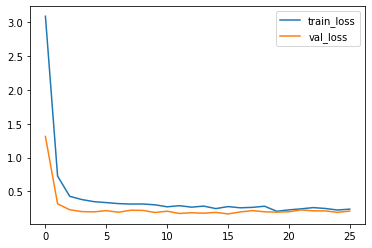

In [ ]:
_ = log.plot()

In [ ]:
log.to_pandas().val_loss.min()

0.3163011968135834

In [ ]:
model.score_in_batches(val)

{'loss': 0.16871365904808044}

## Model Prediction

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
surv

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0.0,0.999870,0.999375,0.999969,0.999880,0.998860,0.998381,0.999700,0.999071,0.999397,0.976803,...,0.999369,0.998748,0.999229,0.999900,0.999770,0.999753,0.998522,0.999353,0.995016,0.999493
1.0,0.999599,0.998110,0.999957,0.999834,0.998541,0.997144,0.999549,0.998131,0.999125,0.971048,...,0.998276,0.997100,0.998410,0.999831,0.999531,0.999343,0.997846,0.998388,0.990902,0.999135
2.0,0.999348,0.997156,0.999928,0.999666,0.998465,0.995245,0.999127,0.996373,0.997712,0.956262,...,0.997065,0.994466,0.997492,0.999572,0.999215,0.998948,0.996479,0.997774,0.988698,0.998393
3.0,0.999222,0.995767,0.999580,0.999507,0.997382,0.993181,0.996198,0.994930,0.997183,0.708951,...,0.996515,0.993822,0.996071,0.998371,0.994779,0.997116,0.995995,0.995771,0.983610,0.997568
4.0,0.998735,0.990750,0.999435,0.999280,0.995996,0.989544,0.994369,0.991405,0.995897,0.691823,...,0.994864,0.992108,0.991464,0.997825,0.992115,0.994336,0.994512,0.991942,0.971664,0.996113
5.0,0.998375,0.988334,0.999181,0.998487,0.995141,0.987057,0.989484,0.988688,0.992392,0.502293,...,0.993214,0.989662,0.989440,0.996513,0.988886,0.992571,0.993325,0.989971,0.964783,0.994143
6.0,0.998234,0.985350,0.998463,0.997897,0.969825,0.982224,0.981499,0.951367,0.988319,0.382843,...,0.992200,0.988300,0.973609,0.994192,0.979770,0.978724,0.991838,0.971633,0.799992,0.990521
7.0,0.998125,0.983407,0.997664,0.995721,0.968460,0.973550,0.972234,0.946409,0.981022,0.255968,...,0.990902,0.984577,0.968383,0.992342,0.977603,0.976419,0.990190,0.967940,0.794067,0.983810
8.0,0.997749,0.976155,0.997098,0.995476,0.917211,0.969105,0.963913,0.933795,0.978521,0.232715,...,0.988908,0.982362,0.959701,0.988879,0.934397,0.965504,0.989179,0.952219,0.632242,0.982095
9.0,0.997178,0.958208,0.996078,0.993526,0.912727,0.958428,0.961182,0.922072,0.970538,0.226753,...,0.977381,0.946715,0.951647,0.987604,0.932018,0.961220,0.984877,0.940516,0.615042,0.977596


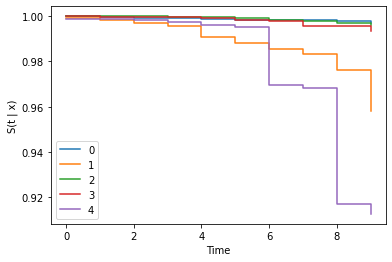

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_test)

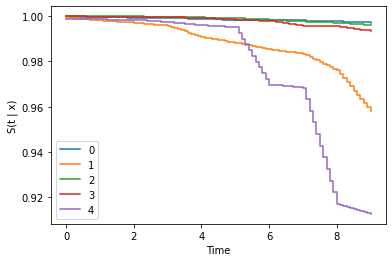

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Model Evaluation

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td('antolini')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.9606741573033708

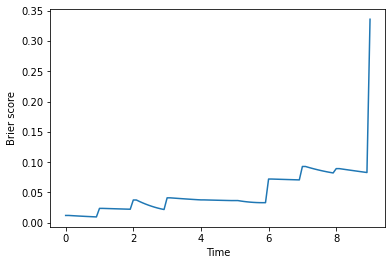

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

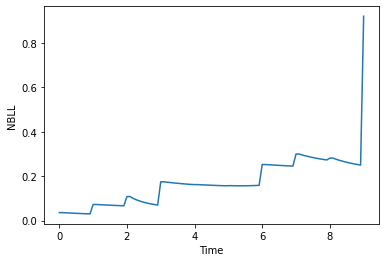

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid) 

0.04814854433525179

In [ ]:
ev.integrated_nbll(time_grid) 

0.16779966545012004

# Di's Data using KL-divergence

## Loading Data

In [ ]:
def dataLong(x):
  Sum = x['time'].sum()
  y = np.zeros((Sum, ))
  indices = np.array(x['time'].cumsum() - 1)
  indices_2 = x["status"] == 1
  indices = indices[indices_2]
  y[indices] = 1

  time_2 = []
  time = np.array(x['time']).tolist()
  for j in time:
    time_2.extend([(i + 1) for i in range(j)])

  columns = x.columns
  x_np = np.array(x)
  n_row = x.shape[0]
  x_long = None
  for i in range(n_row):
    x_np_single = x_np[i]
    x_np_single = np.tile(x_np_single, (time[i], 1))
    if(x_long is None):
      x_long = x_np_single
    else:
      x_long = np.concatenate((x_long, x_np_single), axis = 0)
  
  x = pd.DataFrame(x_long)
  x.columns = columns
  x["y"] = y
  x["time"] = time_2

  time = x["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, 1, axis=1)
  zeros = zeros[:, 1:]

  columns = ['time' + str(i + 1) for i in range(10)]
  x[columns] = zeros

  return x

In [ ]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [ ]:
data_local = data_local.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_local

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
0,0,0.753965,1.627692,0.105189,-0.615590,-1.715804,1,1,0,0,1,5,-1.958141
1,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,6,-6.177399
2,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,10,-1.676150
3,0,-1.223157,0.730813,0.737298,-0.025978,1.042561,1,0,0,1,1,10,-4.000056
4,0,-0.196961,0.517777,-0.218232,0.115463,-1.293901,0,1,1,0,0,8,-2.251158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,-0.124636,-1.061005,0.118523,-1.367860,-1.624387,0,1,0,0,1,7,3.342440
296,0,-0.646082,0.860371,0.197020,0.577851,2.013423,1,1,0,1,1,4,-3.850736
297,0,0.696193,0.668141,0.701740,1.373414,1.983840,1,0,1,1,1,4,-13.846852
298,1,0.508184,0.546064,-1.160606,-1.284907,0.534088,1,1,1,0,1,7,1.142217


In [ ]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data.csv")

In [ ]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,1,0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0,1,0,1,1,7
1,2,0,0.167797,-1.079335,-0.835810,1.251037,1.663017,1,1,0,1,1,9
2,3,0,-0.890850,-1.860280,-1.438631,-1.767561,-1.651210,0,1,1,1,1,6
3,4,0,0.503094,0.138824,-0.481668,-0.958850,-1.150178,1,1,1,0,1,7
4,5,0,-0.137754,1.030716,-0.069327,0.637014,0.618091,1,1,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,-0.915949,-0.087417,0.033986,-0.848910,-0.534234,0,0,1,1,1,5
9996,9997,0,-1.179707,-1.155198,-1.648140,0.384699,1.118215,0,1,1,0,1,3
9997,9998,0,1.233159,-0.280681,0.073404,-1.476220,-0.040967,0,0,1,0,0,3
9998,9999,0,0.011310,0.479807,-0.279155,1.167471,-0.583554,0,1,1,1,0,10


In [ ]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_prior_expanded = dataLong(data_prior)

In [ ]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60116,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60117,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60118,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60119,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Logistic Regression: Finding Parameters for prior data

In [ ]:
columns = ["Z" + str(i + 1) for i in range(10)] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [ ]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.039234
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60121
Model:                          Logit   Df Residuals:                    60101
Method:                           MLE   Df Model:                           19
Date:                Mon, 04 Apr 2022   Pseudo R-squ.:                  0.5507
Time:                        17:43:18   Log-Likelihood:                -2358.8
converged:                       True   LL-Null:                       -5250.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.9501      0.063    -30.814      0.000      -2.074      -1.826
Z2             1.0587      0.057     18.581      0.000       0.947       1.170
Z3            -2.0147      0.071    -28.300      0.000      -2.154      -1.875
Z4            -2.9216      0.085    -34.369      0.000      -3.088      -2.755
Z5             0.9800      0.051     19.192      0.000       0.880       1.080
Z6            -4.0601      0.130    -31.179      0.000      -4.315      -3.805
Z7             1.0388      0.082     12.606      0.000       0.877       1.200
Z8            -2.9127      0.107    -27.306      0.000      -3.122      -2.704
Z9            -3.9679      0.127    -31.187      0.000      -4.217      -3.719
Z10            1.0016      0.082     12.203      0.000       0.841       1.163
time1         -5.8023      0.167    -34.782      0.000      -6.129      -5.475
time2         -6.0537      0.173    -34.971      0.000      -6.393      -5.714
time3         -5.7876      0.174    -33.216      0.000      -6.129      -5.446
time4         -4.7705      0.154    -30.979      0.000      -5.072      -4.469
time5         -4.7717      0.170    -28.050      0.000      -5.105      -4.438
time6         -4.7269      0.191    -24.784      0.000      -5.101      -4.353
time7         -3.2653      0.148    -22.013      0.000      -3.556      -2.975
time8         -3.3771      0.178    -18.924      0.000      -3.727      -3.027
time9         -2.1573      0.164    -13.172      0.000      -2.478      -1.836
time10        -2.3079      0.238     -9.708      0.000      -2.774      -1.842
==============================================================================

Possibly complete quasi-separation: A fraction 0.55 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z" + str(i + 1) for i in range(10)]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [ ]:
Z = np.array(data_local[cova_column])
Z

array([[ 0.75396501,  1.62769188,  0.10518894, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2760782 , -0.08719621,  0.26431448, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.05731115, -1.43343286, -1.69701874, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.6961928 ,  0.66814131,  0.70173958, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.50818426,  0.5460636 , -1.16060572, ...,  1.        ,
         0.        ,  1.        ],
       [-0.24700846, -0.88528335, -1.15691561, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
        4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
       [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
        6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
       [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
        5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
       ...,
       [2.12539341e-09, 1.65289828e-09, 2.15680109e-09, ...,
        2.40252587e-08, 8.13641225e-08, 6.99862434e-08],
       [9.67809776e-03, 7.54442003e-03, 9.81956956e-03, ...,
        9.85860186e-02, 2.65227405e-01, 2.37841743e-01],
       [8.91003239e-03, 6.94437846e-03, 9.04038967e-03, ...,
        9.14797679e-02, 2.49811599e-01, 2.23465231e-01]])

## Putting combined info into Deep Learning

### Our Model

In [ ]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [ ]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [ ]:
data_local

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [ ]:
data_local_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
0,0,0.753965,1.627692,0.105189,-0.615590,-1.715804,1,1,0,0,1,4,-1.958141
1,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,5,-6.177399
2,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,9,-1.676150
3,0,-1.223157,0.730813,0.737298,-0.025978,1.042561,1,0,0,1,1,9,-4.000056
4,0,-0.196961,0.517777,-0.218232,0.115463,-1.293901,0,1,1,0,0,7,-2.251158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0,-0.585137,0.696079,-0.648097,-1.894090,-0.032816,1,0,1,1,1,4,-1.118961
293,0,0.037692,-0.466744,-1.583093,-0.811462,-1.235570,1,0,0,0,1,3,0.718822
294,0,-0.823789,-1.429319,-0.449583,-1.025423,-1.065238,1,0,0,1,1,2,-3.758514
296,0,-0.646082,0.860371,0.197020,0.577851,2.013423,1,1,0,1,1,3,-3.850736


In [ ]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [ ]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
labtrans.cuts

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

(array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
         4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
        [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
         6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
        [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
         5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
        ...,
        [4.66516606e-05, 3.62809675e-05, 4.73410125e-05, ...,
         5.27067554e-04, 1.78250463e-03, 1.53366143e-03],
        [5.40006007e-05, 4.19963092e-05, 5.47985382e-05, ...,
         6.10044634e-04, 2.06267845e-03, 1.77479862e-03],
        [8.91003239e-03, 6.94437846e-03, 9.04038967e-03, ...,
         9.14797679e-02, 2.49811599e-01, 2.23465231e-01]]),
 array([4, 5, 9, 9, 7, 5, 2, 2, 8, 3, 2, 8, 6, 5, 5, 1, 6, 1, 1, 7, 4, 4,
        1, 4, 7, 9, 9, 8, 9, 8, 5, 5, 9, 8, 5, 9, 5, 4, 7, 9, 6, 9, 6, 1,
        4, 3, 3, 2, 3, 6, 0, 4, 8, 7, 9, 9, 9, 9, 7, 3, 1, 2, 7, 5, 8, 2,
        9, 2, 4, 2, 5, 5, 8, 2, 8, 1, 1, 3,

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.1679,	val_loss: 3.7152
1:	[0s / 0s],		train_loss: 3.1563,	val_loss: 2.7178
2:	[0s / 0s],		train_loss: 2.1139,	val_loss: 1.5248
3:	[0s / 0s],		train_loss: 1.0769,	val_loss: 0.7660
4:	[0s / 0s],		train_loss: 0.6144,	val_loss: 0.4804
5:	[0s / 0s],		train_loss: 0.4610,	val_loss: 0.4127
6:	[0s / 0s],		train_loss: 0.3996,	val_loss: 0.3932
7:	[0s / 0s],		train_loss: 0.3727,	val_loss: 0.3781
8:	[0s / 0s],		train_loss: 0.3944,	val_loss: 0.3560
9:	[0s / 0s],		train_loss: 0.4260,	val_loss: 0.3585
10:	[0s / 0s],		train_loss: 0.3518,	val_loss: 0.3446
11:	[0s / 0s],		train_loss: 0.3634,	val_loss: 0.3490
12:	[0s / 0s],		train_loss: 0.3982,	val_loss: 0.3658
13:	[0s / 0s],		train_loss: 0.3529,	val_loss: 0.3337
14:	[0s / 0s],		train_loss: 0.3478,	val_loss: 0.3323
15:	[0s / 0s],		train_loss: 0.3640,	val_loss: 0.3500
16:	[0s / 0s],		train_loss: 0.3509,	val_loss: 0.3424
17:	[0s / 0s],		train_loss: 0.3391,	val_loss: 0.3219
18:	[0s / 0s],		train_loss: 0.3412,	val_loss: 0.3242
19:

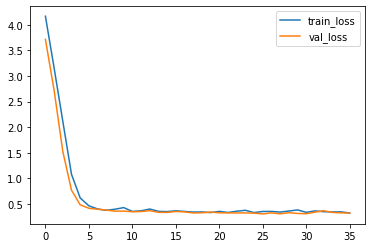

In [ ]:
_ = log.plot()

### Baseline (nnet-survival)

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
y_train = labtrans.fit_transform(*get_target(data_local_train))
y_val = labtrans.transform(*get_target(data_local_val))
# n_train = data_local_train.shape[0]
# n_val = data_local_val.shape[0]
# y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
# y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([4, 5, 9, 9, 7, 5, 2, 2, 8, 3, 2, 8, 6, 5, 5, 1, 6, 1, 1, 7, 4, 4,
        1, 4, 7, 9, 9, 8, 9, 8, 5, 5, 9, 8, 5, 9, 5, 4, 7, 9, 6, 9, 6, 1,
        4, 3, 3, 2, 3, 6, 0, 4, 8, 7, 9, 9, 9, 9, 7, 3, 1, 2, 7, 5, 8, 2,
        9, 2, 4, 2, 5, 5, 8, 2, 8, 1, 1, 3, 4, 9, 7, 1, 1, 9, 8, 4, 4, 7,
        1, 8, 5, 3, 9, 4, 6, 1, 2, 3, 9, 2, 9, 5, 2, 7, 5, 3, 0, 6, 9, 8,
        7, 8, 4, 9, 7, 4, 2, 3, 2, 5, 4, 4, 6, 9, 0, 7, 9, 9, 5, 4, 9, 2,
        8, 4, 1, 1, 3, 9, 1, 4, 8, 8, 1, 4, 0, 4, 9, 5, 8, 8, 8, 3, 4, 6,
        3, 3, 8, 4, 1, 0, 1, 2, 3, 4, 4, 9, 9, 3, 8, 6, 7, 2, 7, 0, 4, 5,
        5, 4, 4, 4, 2, 2, 5, 4, 8, 8, 4, 4, 3, 2, 3, 5]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0.

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.9768,	val_loss: 3.6329
1:	[0s / 0s],		train_loss: 3.0612,	val_loss: 2.6323
2:	[0s / 0s],		train_loss: 1.9888,	val_loss: 1.4241
3:	[0s / 0s],		train_loss: 1.0475,	val_loss: 0.6004
4:	[0s / 0s],		train_loss: 0.5119,	val_loss: 0.3142
5:	[0s / 0s],		train_loss: 0.3585,	val_loss: 0.2408
6:	[0s / 0s],		train_loss: 0.4046,	val_loss: 0.2461
7:	[0s / 0s],		train_loss: 0.2765,	val_loss: 0.2673
8:	[0s / 0s],		train_loss: 0.2524,	val_loss: 0.2568
9:	[0s / 0s],		train_loss: 0.2570,	val_loss: 0.2689
10:	[0s / 0s],		train_loss: 0.2409,	val_loss: 0.2847
11:	[0s / 0s],		train_loss: 0.2279,	val_loss: 0.3007
12:	[0s / 0s],		train_loss: 0.1891,	val_loss: 0.2675
13:	[0s / 0s],		train_loss: 0.2059,	val_loss: 0.2672
14:	[0s / 0s],		train_loss: 0.1872,	val_loss: 0.2696
15:	[0s / 0s],		train_loss: 0.1691,	val_loss: 0.2750


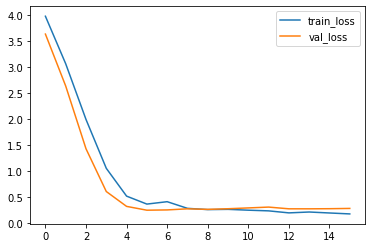

In [ ]:
_ = log.plot()

In [ ]:
log.to_pandas().val_loss.min()

0.24076062440872192

## Evaluation

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


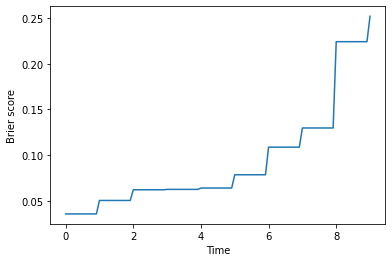

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

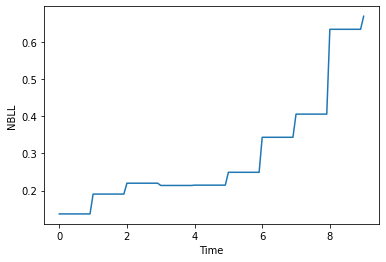

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid) 

0.09176995443645528

In [ ]:
ev.integrated_nbll(time_grid) 

0.29252012928659815

# Multiple Experiments

In [ ]:
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


1
0:	[0s / 0s],		train_loss: 4.0335,	val_loss: 3.4021
1:	[0s / 0s],		train_loss: 3.1186,	val_loss: 2.3695
2:	[0s / 0s],		train_loss: 1.9911,	val_loss: 1.3160
3:	[0s / 0s],		train_loss: 1.0384,	val_loss: 0.6688
4:	[0s / 0s],		train_loss: 0.5710,	val_loss: 0.4640
5:	[0s / 0s],		train_loss: 0.4444,	val_loss: 0.3955
6:	[0s / 0s],		train_loss: 0.3721,	val_loss: 0.3469
7:	[0s / 0s],		train_loss: 0.3651,	val_loss: 0.3560
8:	[0s / 0s],		train_loss: 0.3964,	val_loss: 0.3473
9:	[0s / 0s],		train_loss: 0.3778,	val_loss: 0.3267
10:	[0s / 0s],		train_loss: 0.4275,	val_loss: 0.3267
11:	[0s / 0s],		train_loss: 0.3622,	val_loss: 0.3673
12:	[0s / 0s],		train_loss: 0.3718,	val_loss: 0.3564
13:	[0s / 0s],		train_loss: 0.3470,	val_loss: 0.3347
14:	[0s / 0s],		train_loss: 0.3491,	val_loss: 0.3242
15:	[0s / 0s],		train_loss: 0.3424,	val_loss: 0.3467
16:	[0s / 0s],		train_loss: 0.3365,	val_loss: 0.3402
17:	[0s / 0s],		train_loss: 0.3204,	val_loss: 0.3300
18:	[0s / 0s],		train_loss: 0.3709,	val_loss: 0.3376
1

In [ ]:
concordance_td_list 
integrated_brier_score_list 
integrated_nbll_list 
likelihood_list

[0.9581005586592178,
 0.9720670391061452,
 0.9636871508379888,
 0.9664804469273743,
 0.9245810055865922,
 0.9413407821229051,
 0.9692737430167597,
 0.952513966480447,
 0.9664804469273743,
 0.952513966480447,
 0.946927374301676,
 0.9441340782122905,
 0.9357541899441341,
 0.9553072625698324,
 0.9581005586592178,
 0.9692737430167597,
 0.9720670391061452,
 0.9720670391061452,
 0.9553072625698324,
 0.9720670391061452,
 0.946927374301676,
 0.9413407821229051,
 0.9441340782122905,
 0.9217877094972067,
 0.9664804469273743,
 0.9720670391061452,
 0.9720670391061452,
 0.9301675977653632,
 0.9636871508379888,
 0.9329608938547486,
 0.9553072625698324,
 0.9581005586592178,
 0.9636871508379888,
 0.9497206703910615,
 0.9581005586592178,
 0.9720670391061452,
 0.9329608938547486,
 0.946927374301676,
 0.9748603351955307,
 0.9357541899441341,
 0.9441340782122905,
 0.946927374301676,
 0.952513966480447,
 0.9692737430167597,
 0.9608938547486033,
 0.952513966480447,
 0.9636871508379888,
 0.9553072625698324,


In [ ]:
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0:	[0s / 0s],		train_loss: 4.0182,	val_loss: 3.4819
1:	[0s / 0s],		train_loss: 3.1004,	val_loss: 2.3930
2:	[0s / 0s],		train_loss: 1.9936,	val_loss: 1.2868
3:	[0s / 0s],		train_loss: 0.9737,	val_loss: 0.5873
4:	[0s / 0s],		train_loss: 0.5272,	val_loss: 0.3766
5:	[0s / 0s],		train_loss: 0.3779,	val_loss: 0.3213
6:	[0s / 0s],		train_loss: 0.3121,	val_loss: 0.2866
7:	[0s / 0s],		train_loss: 0.2742,	val_loss: 0.2815
8:	[0s / 0s],		train_loss: 0.2649,	val_loss: 0.2980
9:	[0s / 0s],		train_loss: 0.2401,	val_loss: 0.2781
10:	[0s / 0s],		train_loss: 0.2740,	val_loss: 0.3127
11:	[0s / 0s],		train_loss: 0.1805,	val_loss: 0.4177
12:	[0s / 0s],		train_loss: 0.2578,	val_loss: 0.3355
13:	[0s / 0s],		train_loss: 0.1963,	val_loss: 0.3504
14:	[0s / 0s],		train_loss: 0.1976,	val_loss: 0.3948
15:	[0s / 0s],		train_loss: 0.1775,	val_loss: 0.3196
16:	[0s / 0s],		train_loss: 0.1566,	val_loss: 0.2844
17:	[0s / 0s],		train_loss: 0.1331,	val_loss: 0.3064
18:	[0s / 0s],		train_loss: 0.1429,	val_loss: 0.3604
19:

In [ ]:
concordance_td_list_old
integrated_brier_score_list_old
integrated_nbll_list_old
likelihood_list_old

[0.4247380495071411,
 0.32691219449043274,
 0.3465552031993866,
 0.3032931685447693,
 0.3527112305164337,
 0.4132464826107025,
 0.28458476066589355,
 0.3529897928237915,
 0.36818060278892517,
 0.3728741407394409,
 0.27319255471229553,
 0.24896347522735596,
 0.46233752369880676,
 0.38827216625213623,
 0.40005144476890564,
 0.36221298575401306,
 0.3544429838657379,
 0.3129523694515228,
 0.3676260709762573,
 0.41004011034965515,
 0.4175356924533844,
 0.3897447884082794,
 0.3422633707523346,
 0.3515278100967407,
 0.42519769072532654,
 0.3781871795654297,
 0.37540197372436523,
 0.33128806948661804,
 0.39106181263923645,
 0.300410658121109,
 0.48483291268348694,
 0.3269166648387909,
 0.3162047266960144,
 0.3855911195278168,
 0.29969969391822815,
 0.3466995656490326,
 0.3249633312225342,
 0.43330898880958557,
 0.3280699551105499,
 0.36195817589759827,
 0.38046547770500183,
 0.3852405846118927,
 0.3724348545074463,
 0.2786918878555298,
 0.36289045214653015,
 0.4271024167537689,
 0.378692150115

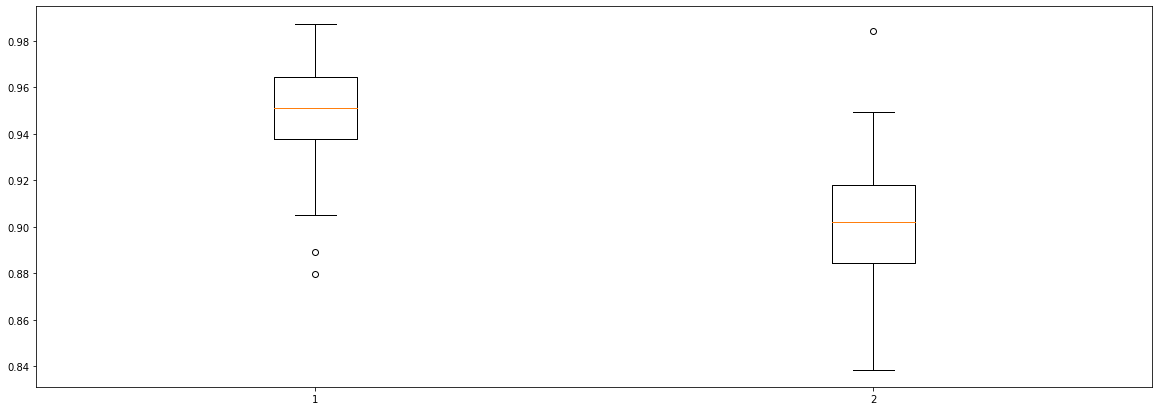

In [ ]:
fig = plt.figure(figsize =(20, 7))

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

plt.boxplot([concordance_td_array, concordance_td_array_old])

# show plot
plt.show()

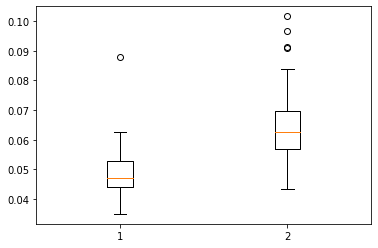

In [ ]:
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old])
plt.show()

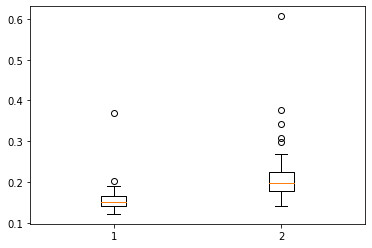

In [ ]:
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old])
plt.show()

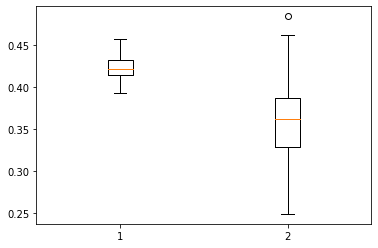

In [ ]:
plt.boxplot([likelihood_array, likelihood_array_old])
plt.show()

# Extension: Prior with deep learning?

In [ ]:
# Due to the starter number difference between Python and R
data_prior['time'] = data_prior['time'] - 1

In [ ]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_prior_mapper = DataFrameMapper(standardize + leave)

In [ ]:
data_prior_test = data_prior.sample(frac=0.2)
data_prior_train = data_prior.drop(data_prior_test.index)
data_prior_val = data_prior_train.sample(frac=0.2)
data_prior_train = data_prior_train.drop(data_prior_val.index)

In [ ]:
data_prior_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
3,0,0.503094,0.138824,-0.481668,-0.958850,-1.150178,1,1,1,0,1,6
4,0,-0.137754,1.030716,-0.069327,0.637014,0.618091,1,1,1,0,0,5
7,0,0.755846,0.482250,-0.088956,-1.495857,-1.826243,0,1,1,0,0,9
8,0,-0.094970,0.602343,1.076478,0.478586,1.512609,1,0,1,1,0,9
10,0,1.153147,0.926107,1.163974,0.893223,1.126522,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,-0.692818,-0.392717,0.679147,1.170516,-0.060998,1,1,1,0,1,7
9995,0,-0.915949,-0.087417,0.033986,-0.848910,-0.534234,0,0,1,1,1,4
9996,0,-1.179707,-1.155198,-1.648140,0.384699,1.118215,0,1,1,0,1,2
9997,0,1.233159,-0.280681,0.073404,-1.476220,-0.040967,0,0,1,0,0,2


In [ ]:
data_prior_train_index = np.array(data_prior_train.index)
data_prior_val_index = np.array(data_prior_val.index)

In [ ]:
x_train = data_prior_mapper.fit_transform(data_prior_train).astype('float32')
x_val = data_prior_mapper.transform(data_prior_val).astype('float32')
x_test = data_prior_mapper.transform(data_prior_test).astype('float32')

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
y_train = labtrans.fit_transform(*get_target(data_prior_train))
y_val = labtrans.transform(*get_target(data_prior_val))
# n_train = data_local_train.shape[0]
# n_val = data_local_val.shape[0]
# y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
# y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_prior_test)

In [ ]:
labtrans.cuts

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([6, 5, 9, ..., 2, 2, 9]),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6588,	val_loss: 0.2911
1:	[1s / 2s],		train_loss: 0.3151,	val_loss: 0.2794
2:	[6s / 8s],		train_loss: 0.3078,	val_loss: 0.2825
3:	[5s / 13s],		train_loss: 0.3001,	val_loss: 0.2861
4:	[4s / 18s],		train_loss: 0.2911,	val_loss: 0.2872
5:	[1s / 20s],		train_loss: 0.2969,	val_loss: 0.2725
6:	[0s / 21s],		train_loss: 0.2951,	val_loss: 0.3027
7:	[0s / 21s],		train_loss: 0.2944,	val_loss: 0.2804
8:	[0s / 22s],		train_loss: 0.2854,	val_loss: 0.2757
9:	[0s / 23s],		train_loss: 0.2865,	val_loss: 0.2799
10:	[0s / 23s],		train_loss: 0.2794,	val_loss: 0.2677
11:	[0s / 24s],		train_loss: 0.2709,	val_loss: 0.2814
12:	[0s / 25s],		train_loss: 0.2753,	val_loss: 0.2752
13:	[0s / 26s],		train_loss: 0.2806,	val_loss: 0.2792
14:	[0s / 26s],		train_loss: 0.2720,	val_loss: 0.2829
15:	[0s / 27s],		train_loss: 0.2743,	val_loss: 0.2769
16:	[0s / 28s],		train_loss: 0.2679,	val_loss: 0.2828
17:	[0s / 28s],		train_loss: 0.2664,	val_loss: 0.2847
18:	[0s / 29s],		train_loss: 0.2659,	val_

In [ ]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
prior_info_train = model.predict_hazard(x_train)
prior_info_val = model.predict_hazard(x_val)

In [ ]:
prior_info.shape

(300, 10)

In [ ]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
zeros_train = zeros[data_local_train_index]
zeros_val = zeros[data_local_val_index]

In [ ]:
eta = 10
combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info_train, data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info_val, data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train[0].shape

# TODO: Fill in the data with the expanded version of data in the first line

(192, 10)

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.0784,	val_loss: 3.5575
1:	[0s / 0s],		train_loss: 3.1741,	val_loss: 2.5076
2:	[0s / 0s],		train_loss: 2.0175,	val_loss: 1.3588
3:	[0s / 0s],		train_loss: 1.0285,	val_loss: 0.6863
4:	[0s / 0s],		train_loss: 0.6025,	val_loss: 0.4635
5:	[0s / 0s],		train_loss: 0.4181,	val_loss: 0.3897
6:	[0s / 0s],		train_loss: 0.5380,	val_loss: 0.3548
7:	[0s / 0s],		train_loss: 0.3879,	val_loss: 0.3735
8:	[0s / 0s],		train_loss: 0.4217,	val_loss: 0.3615
9:	[0s / 0s],		train_loss: 0.3760,	val_loss: 0.3407
10:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3322
11:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3289
12:	[0s / 0s],		train_loss: 0.3855,	val_loss: 0.3255
13:	[0s / 0s],		train_loss: 0.3507,	val_loss: 0.3245
14:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3151
15:	[0s / 0s],		train_loss: 0.3632,	val_loss: 0.3213
16:	[0s / 0s],		train_loss: 0.3476,	val_loss: 0.3243
17:	[0s / 0s],		train_loss: 0.3891,	val_loss: 0.3244
18:	[0s / 0s],		train_loss: 0.3557,	val_loss: 0.3306
19:

In [ ]:
concordance_td_list_prior_deep = []
integrated_brier_score_list_prior_deep = []
integrated_nbll_list_prior_deep = []
likelihood_list_prior_deep = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train, data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_val, data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_prior_deep.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_prior_deep.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_prior_deep.append(ev.integrated_nbll(time_grid))
  likelihood_list_prior_deep.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.0136,	val_loss: 3.5298
1:	[0s / 0s],		train_loss: 3.1304,	val_loss: 2.4920
2:	[0s / 0s],		train_loss: 1.9981,	val_loss: 1.3823
3:	[0s / 0s],		train_loss: 0.9923,	val_loss: 0.7168
4:	[0s / 0s],		train_loss: 0.5651,	val_loss: 0.5003
5:	[0s / 0s],		train_loss: 0.4321,	val_loss: 0.4312
6:	[0s / 0s],		train_loss: 0.3955,	val_loss: 0.4022
7:	[0s / 0s],		train_loss: 0.4010,	val_loss: 0.3914
8:	[0s / 0s],		train_loss: 0.3994,	val_loss: 0.3887
9:	[0s / 0s],		train_loss: 0.4195,	val_loss: 0.3777
10:	[0s / 0s],		train_loss: 0.3725,	val_loss: 0.3774
11:	[0s / 0s],		train_loss: 0.4088,	val_loss: 0.3993
12:	[0s / 0s],		train_loss: 0.3620,	val_loss: 0.4007
13:	[0s / 0s],		train_loss: 0.3766,	val_loss: 0.3872
14:	[0s / 0s],		train_loss: 0.3432,	val_loss: 0.3724
15:	[0s / 0s],		train_loss: 0.3807,	val_loss: 0.3845
16:	[0s / 0s],		train_loss: 0.3471,	val_loss: 0.3809
17:	[0s / 0s],		train_loss: 0.3777,	val_loss: 0.3610
18:	[0s / 0s],		train_loss: 0.3646,	val_loss: 0.3497
1

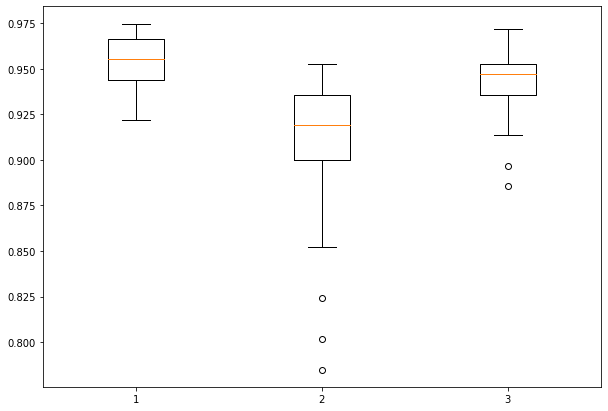

In [ ]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
concordance_td_array_prior_deep = np.array(concordance_td_list_prior_deep)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_brier_score_array_prior_deep = np.array(integrated_brier_score_list_prior_deep)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
integrated_nbll_array_prior_deep = np.array(integrated_brier_score_list_prior_deep)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)
likelihood_array_prior_deep = np.array(likelihood_list_prior_deep)

plt.boxplot([concordance_td_array, concordance_td_array_old, concordance_td_array_prior_deep])

# show plot
plt.show()

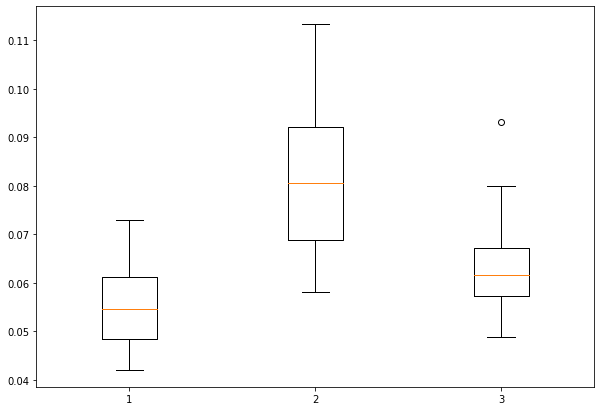

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old, integrated_brier_score_array_prior_deep])
plt.show()

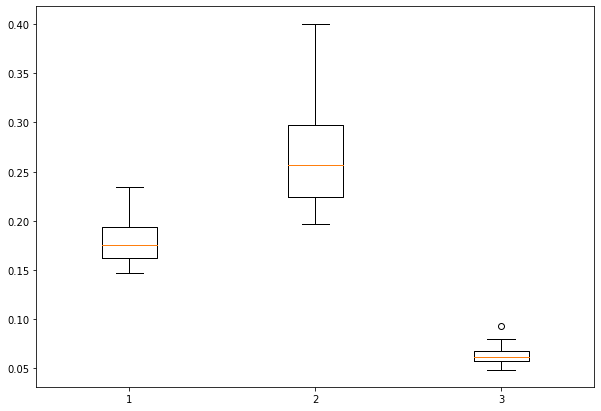

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old, integrated_nbll_array_prior_deep])
plt.show()

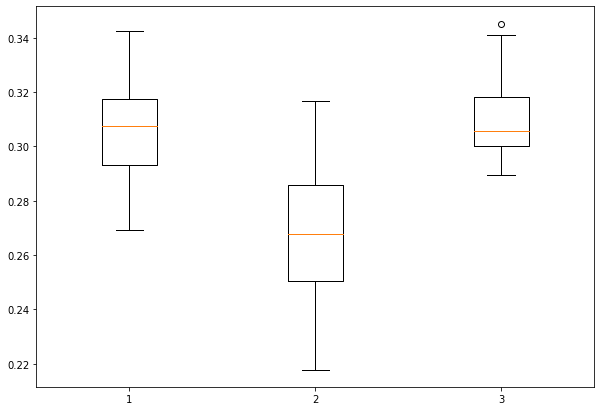

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([likelihood_array, likelihood_array_old, likelihood_array_prior_deep])
plt.show()

# Appendix

## Comparison

In [ ]:
import torch.nn.functional as F 
events = y_train[1]
idx_durations = y_train[0]
events = torch.tensor(events)
idx_durations = torch.tensor(idx_durations)

events = events.reshape(-1, 1)
idx_durations = idx_durations.reshape(-1, 1)
phi = torch.ones(192, 10) / 10
y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events) # TODO: Data Expansion!
bce = F.binary_cross_entropy_with_logits(phi, y_bce, reduction='none')
loss = bce.cumsum(1).gather(1, idx_durations).view(-1)

In [ ]:
y_bce[0, 7]

tensor(0.)

In [ ]:
loss.mean()

tensor(4.4355)

In [ ]:
events = y_train[1]
idx_durations = y_train[0]
events = torch.tensor(events)
idx_durations = torch.tensor(idx_durations)
combined_info_train = torch.tensor(combined_info[data_local_train_index])

events = events.view(-1, 1)
idx_durations = idx_durations.view(-1, 1)
phi = torch.ones(192, 10) / 10
# y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events)  # TODO: Data Expansion!
bce = F.binary_cross_entropy_with_logits(phi, combined_info_train, reduction='none')
loss = bce.cumsum(1).gather(1, idx_durations).view(-1)

In [ ]:
loss.mean()

tensor(4.4355, dtype=torch.float64)